# AutoGrad

Using the backward and forward operations to get the gadient of the loss function in a fast way. This can work for all different things, but very useful in neural nets.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Derivatives

Lets investigate the derivatives

In [2]:
def f(x):
  return x**2 - 3*x - 10

In [3]:
f(3)

-10

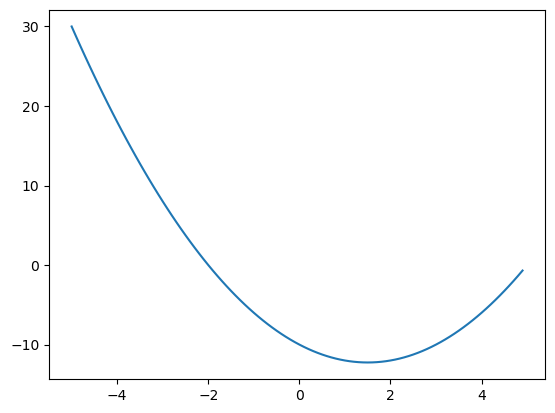

In [4]:
x = np.arange(-5, 5, 0.1)
y = f(x)
plt.plot(x, y)

In [5]:
# lets find the derivative of the function. instead we will look to the definition of a derivative to solve our problem
def derivative(function, x, d_x):
  return (function(x + d_x) - function(x)) / d_x




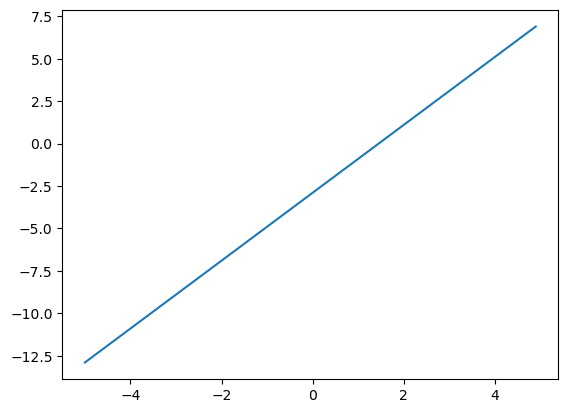

In [6]:
dy_dx = derivative(f, x, 0.1)
plt.plot(x, dy_dx)

# Our Own Value class

In [7]:
class Value:
    """ This value class allows for the storage and quick computation of variables in the forward and backward pass. See the below markdown for more info on the details of what a bacward pass is!
    """
    def __init__(self, value, _children=(), _op='', label=''):
        """Creates a new instance of a value object.

        Args:
            value ([type]): The value of the object
            children (tuple, optional): [description]. Defaults to ().
            operation (tuple, optional): A tuple containing the operation. Defaults to ().
        """
        self.data = value 
        self._prev = set(_children)
        self._backward = lambda: None
        self.grad = 0 # note that zero means that changiing this variable does not change the loss function. 
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value({self.data})"
        
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def backward():
            # no multiplier for a derivative of 1
            # for each instance you have to add the out gradient. BUG ALERT, if you had not added them and just set them equal to the out.grad it would mean that adding to of the same values would make it so thier derivatives were 1 and not 2. 
            self.grad += out.grad
            other.grad += out.grad

        out._backward = backward
        return out
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)

        out = Value(self.data * other.data, (self, other), "*")

        def backward():
            # chain rule causes you to multiply them by each other.
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = backward
        return out
    
    def __pow__(self, other):
        # only supporting integer and float. 
        assert isinstance(other, (int, float))
        # if other = 0 we have to use a different differiantion rule. Note that this is jus a multiplation by 0. 
        assert other != 0

        out = Value(self.data ** other, (self,), f'^{other}')

        def backward():
            # power rule 
            self.grad += other * self.data ** (other - 1) * out.grad

        out._backward = backward
        return out

    def tanh(self):
        """A commonly used activation function; hyperbolic tangent. 

        Returns:
            Value: A new value instance which contains the object called on as a child. 
        """
        out = Value(np.tanh(self.data), (self,), "tanh")

        def backward():
            self.grad += (1 - np.tanh(out.data) ** 2) * out.grad
        
        out._backward = backward

        return out
    
    def exp(self):
        out = Value(np.exp(self.data), (self,), "exp")

        def backward():
            # note that becuase the derivative of e^x is e^x this expression is rather trivial. 
            self.grad += out.data * out.grad
        
        out._backward = backward

        return out
    
    def relu(self):
        out = Value(np.maximum(self.data, 0), (self,), "relu")

        def backward():
            # relu derivative is 1 if the value is positive and 0 if it is negative. 
            self.grad += (out.data > 0) * out.grad

        out._backward = backward

        return out



    def backward_prop(self):
        """Calls all the backward propogation starting at this node, backfilling the gradients in the map that is connected to this value. 
        """

        # you have to reset the gradient to 1 or else it will not work. The intiuation behind this is that the derivative of this value with respect to itself is 1. 
        self.grad = 1

        # in this list we will fill a list that fills it from left to right s.t. all node children are to the left of their parent
        topological_list = []

        def build_topo(v):
            """A recurisve method used to fill a "list" with an ordered set of nodes s.t. all children are garunteed to be before their parent. 

            Args:
                v (Value): The value node you would like to build your list off of.
            """

            # first we identify if v has already been placed in the list. 
            if v not in topological_list:

                # Now we iterate through each of children adn create their own topo map. 
                for child in v._prev:
                    build_topo(child)

                # note that due to the recursive structure of these calls, we only make it here once we have reached the tail of this map. 
                topological_list.append(v)

                # after adding the entry to to the list we end and then go to the next value in the callstack and append it to the list. 
                # by doing it this way it garuntees that all children will be added before their parents. 

        build_topo(self)
        # note that we want this reversed here becuase we want to call the list from right to left. Starting with the parents and moving through to the children. 
        for node in reversed(topological_list):
            # calls each node's backward function to backfill all the gradients. 
            node._backward()


    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"





In [8]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [9]:
# draw_dot(d)

 # Reminder of Chain Rule 
Given functions $f(x), g(x)$ we can derive thier compound product as follows $\frac{d}{dx}f(g(x)) = \frac{df}{dg} \frac{dg}{dx}$.c

This ideas proves very valuable when thinking about the idea of back propogation in your function map. Lets look at the above graph. 


Lets say we have weight $w_1$. Through a "function" which I am modelling as a simple neural network $f(x) = 5 * (\alpha + (x^2))$. This function $f(x)$ can be easily redefined as the following, where 
1. $g(x) = 5 * x$
2. $h(x) = \alpha + x$
3. $r(x) = x^2$

If we were solving this derivative in math class, we could solve the derivative directly. But there is a different approach which is more valuable in this situiation. 
A quick reminder that $\frac{df}{dx} = \frac{dg}{dh}\frac{dh}{dr}\frac{dr}{dx}$

The name of the game is computation time, so a clever idea would be to be able to store each of these values and then go back and access them when you needed to calculate the entire derivative. In our case we know that $g'(x) = 5$, $h'(x) = 1$, and $r'(x) = 2x$. That will allow us to calculate the derivative of our function $f'(x) = 10x$. 

### What advantage does this storage of derivastive actually do to help us speed up computational time??c
The reason this is so helpful is becuase if we have many functions which we need to calculate derivatives of we can easily repeat our previously calculated values to drastically shorten computational time. 

### Important Notes 
For the following classes of operations the derivatives are as follows: 
1. Addition/Subtraction $\frac{d}{dx}(\alpha + x) = 1$
2. Multiplcation/Division $\frac{d}{dx}(\alpha * x) = \alpha$
3. Exponentiation $\frac{d}{dx}(x^{\alpha}) = \alpha * x^{\alpha-1}$

There are others out there but these base cases can handle it mostly.

### How do we turn insights into an algorithm to calculate the gradient of a value??
Image we are solving for the value of a function, that we think of as moving forward through a function to find its value. For calculating a derviative we are now gonna go from back to front. For each function we will calulcate its derivative jus like we did in the above example except now we will be doing it with code. 

We can approach this with the idea of every function containg a forward pass which is very familiar to us, but then also a backwards pass which is much less intiuative. vUsing the example seen above lets say we start at $g(x)$, we define the backward pass to be the derivative of the function times the derivative of $h(x)$, but since $h(x)$ is one of the children of $g(x)$ we can define $g(x)$ backwards function to be the **derivative of $g(x)$ times the derivative of its child. 

This similar pattern can be seen for all different types of functions. The note to be careful of is the chain rule for multivariable functions. 
let $F(x, y) = F(g(x, y), h(x, y))$ then $ \frac{\partial F}{\partial x} = \frac{\partial F}{\partial g} \frac{\partial g}{\partial x} + \frac{\partial F}{\partial h}\frac{\partial h}{\partial x} $. This is something to be careful of when defining the backward passes of functions of adding and multiplying. 

## So to summarize:

1. For addition we can define the pass to be:

$ F(g(x_1, x_2,...,x_{n}), h(x_1, x_2,...,x_{n})) = g + h \to \frac{\partial F}{\partial x_i} = \frac{\partial g}{\partial x_i} + \frac{\partial h}{\partial x_i}$
Note that this function will only be called if the path is known to be a part of $x_i$

2. For multiplication we can define the pass to be:

$ F(g(x_1, x_2,...,x_{n}), h(x_1, x_2,...,x_{n})) = g * h \to \frac{\partial F}{\partial x_i} = h * \frac{\partial g}{\partial x_i} + g * \frac{\partial h}{\partial x_i}$

... Continued. 






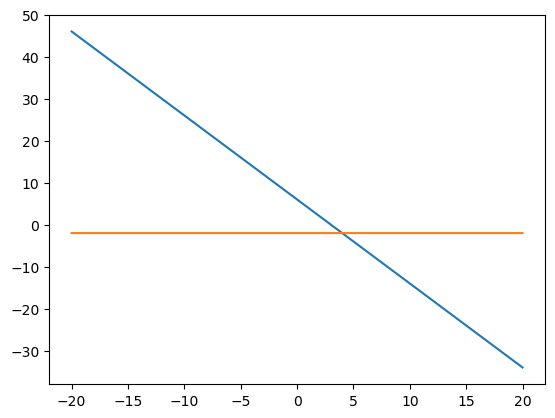

In [10]:
# here we explore the gradient solving for what the value is approximatly via some value h. 
def some_function(val):
    a = Value(val, label='a')
    b = Value(-3, label='b')
    c = Value(10.0, label='c')

    e = a + b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0); f.label = 'f'
    L = e*f; L.label = 'L'

    return L

h = 0.0001

values = np.linspace(-20, 20, 10**5)
d_dVal = []

for value in values:
    d_dVal.append((some_function(value + h).data - some_function(value).data) / h)

plt.plot(values, some_function(values).data)
plt.plot(values, d_dVal)

    
    

# Visualizing Back propogation

We will explore a manual driven backward propogation. 

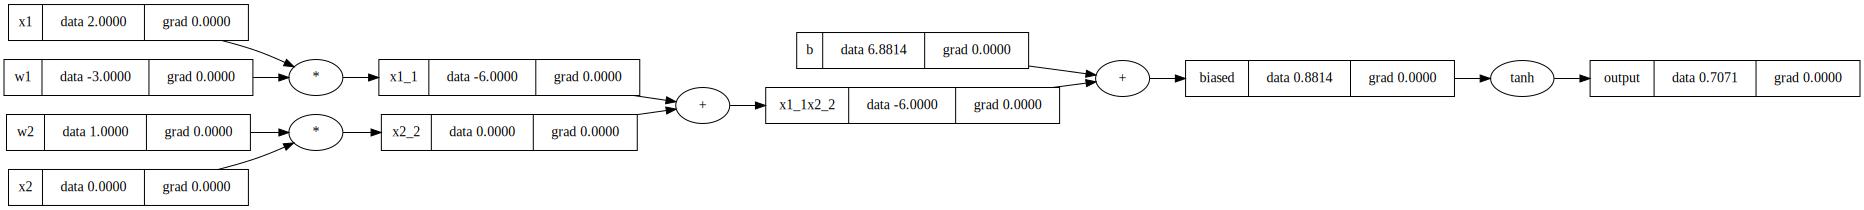

In [11]:
# lets make a somple neuron here and map it 

# x1 and x2 are inputs to the network
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# w1 and w2 are the weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of neuron 
b = Value(6.88137, label='b')

# inner workings of the neuron 
x1_1 = x1 * w1; x1_1.label = 'x1_1'
x2_2 = x2 * w2; x2_2.label = 'x2_2'
x1_1x2_2 = x1_1 + x2_2; x1_1x2_2.label = 'x1_1x2_2'
biased = x1_1x2_2 + b; biased.label = 'biased'
output = biased.tanh(); output.label = 'output'



draw_dot(output)



In [12]:
# lets try it with our newly minted value class with back propogation. 

# The below process will do the back propogation in and easy to read an understand process
output.grad = 1.0
output._backward()
biased._backward()
x1_1x2_2._backward()
x2_2._backward()
x1_1._backward()


In [13]:
# this below process will allow you to just call a function on the root node to calucate all the gradients in its children. 

output.backward_prop()

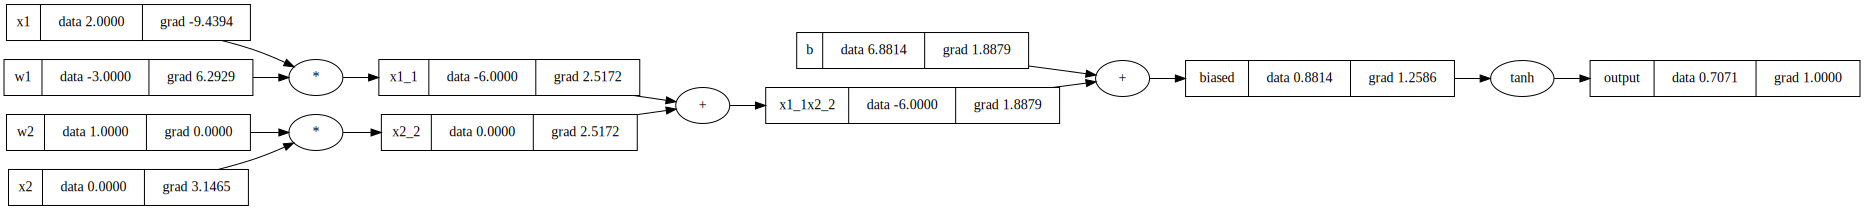

In [14]:
draw_dot(output)

## Lets investigate a bug in our current implementation. 

Forward propogation is working fine. Lets say you multiply $a + a$ than you get a final expression of $ 2a $. However, in our current implementation we are not dealing with the fact that the derivative of $\frac{d}{da}2a = 2 $ not $ 1 $ which is the current implemantation of the gradient. Interestingly, my implementation does not have the same bug that Andrej has identified. rHowever, the error is caused whenever you use a variable twice which makes sense becuase the backwards propogation is adding to different pathways to their values. This causes all types of undefined behavior. 



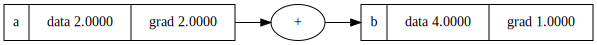

In [15]:
# simple case to demonstrate the issue. 
a = Value(2.0, label='a')
b = a + a; b.label = 'b'
b.backward_prop()
draw_dot(b)

# Pytorch 

Ideas of this gradient toolkit is softly modelled after pyTorch, the code below will explore that fact

In [16]:
import torch

x1 = torch.Tensor([2.0]); x1.requires_grad = True
x2 = torch.Tensor([0.0]); x2.requires_grad = True
w1 = torch.Tensor([-3.0]); w1.requires_grad = True
w2 = torch.Tensor([1]); w2.requires_grad = True
b = torch.Tensor([6.88137358]); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print("w1", w1.grad.item())
print('w2', w2.grad.item())


0.7071067094802856
----
x2 0.5000001192092896
x1 -1.5000003576278687
w1 1.000000238418579
w2 0.0


In [17]:
import random

## Neural Network classes

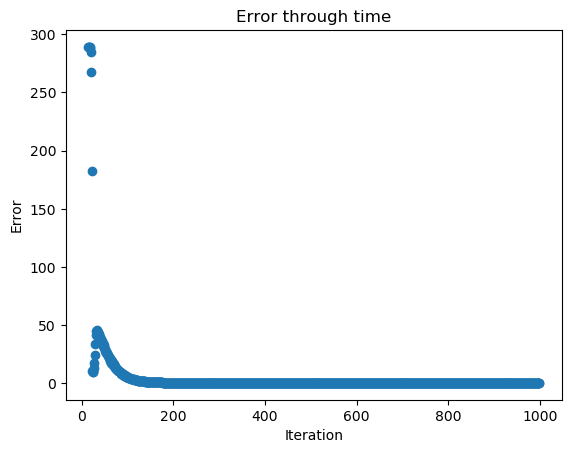

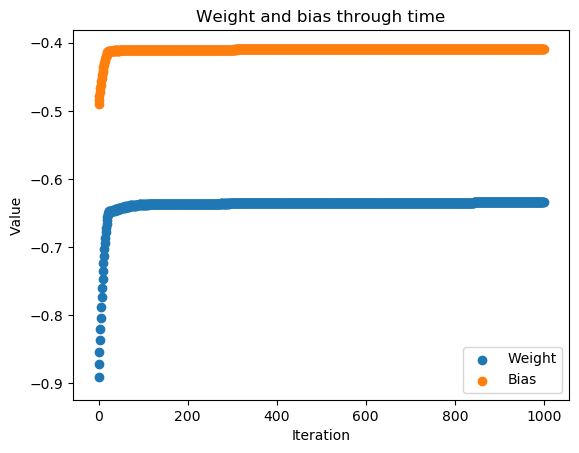

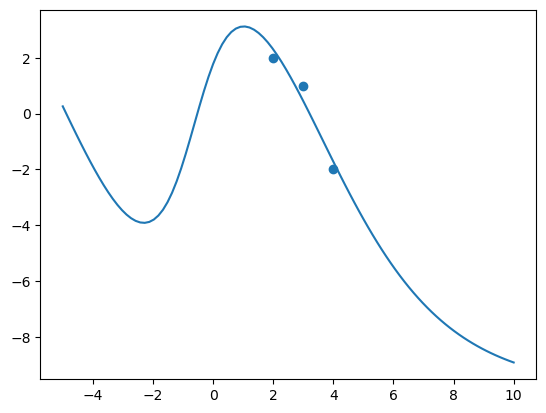

In [94]:
class Neuron:
    def __init__(self, input_count, activiation_function=Value.tanh):
        """Creates a new Neuron object

        Args:
            input_count ([type]): The number of inputs that this neruon will need weights for.
            activiation_function ([type], optional): The non-linear activation function used for this neuron. Defaults to Value.tanh.
        """
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(input_count)]
        self.bias = Value(random.uniform(-1, 1))
        self.activationFunction = activiation_function
    
    def __call__(self, x):
        """Calculates the value of this neuron

        Args:
            x (list[Value]): A list ofr the same size of the number of weights in this neuron. 

        Returns:
            [type]: The value outputting by the neuron during forward propogation. 
        """
        raw_sum = sum((w * b for w, b in zip(self.weights, x)), self.bias)
        

        return self.activationFunction(raw_sum)
    
    def parameters(self):
        """ Gets a list of the modifiable paramters in this neuron. 

        Returns:
            list([Value]): A list containing the modifiable paramters in this neuron. 
        """
        return self.weights + [self.bias]
    
class Layer:
    
        
    def __init__(self, input_count, output_count, activiation_function=Value.tanh):
        """ Creates a new layer instance

        Args:
            input_count (int): Number of inputs into this layer. 
            output_count (int): Number of outputs out of this layer.
        """
        # creates 'outout_count' neurons that have 'input_count' weights. 
        self.neurons = [Neuron(input_count, activiation_function) for _ in range(output_count)]

    def __call__(self, x):
        """Calculates the value of this layer

        Args:
            x (list[Value]): A list of the same size of the number of inputs in this layer. 

        Returns:
            [type]: A list of the same size of the number of neurons in this layer. 
        """
        return [n(x) for n in self.neurons]
    
    def parameters(self) -> list([Value]):
        """Gets a list containing references to all the paramaters in this layer

        Returns:
            [Value]: A list containing all the paramaters in this layer
        """
        params = []
        for neuron in self.neurons:
            param_list = neuron.parameters()
            params.extend(param_list)
        return params
    
w = []
b = []
iteration = []
errors = []
    
class Network:

    def mean_squared_error(predicted, expected):
        return (predicted - expected) ** 2
    
    def tanh_times_10(x):
        return 10 * x.tanh()
    

    def __init__(self, layer_data, activation_function=Value.tanh):
        """Creates a new neural network from the given paramters. 

        Args:
            layer_data (list[int]): A list of int's containing the size of each layer 
        """

        if len(layer_data) == 1:
            self.layers = [Layer(layer_data[0], layer_data[0], activation_function)]
        else:
            self.layers = [Layer(layer_data[i], layer_data[i+1], activation_function) for i in range(len(layer_data) - 1)]
       


    def __call__(self, x):
        """Calculates the output of the network

        Args:
            x (list[Value]): A list of the same size of the number of inputs in the first layer. 

        Returns:
            list[Value]: A list of the same size of the number of neurons in the last layer. 
        """

        # for each layer we input the last x value and replace the x value with the new output from that layer. 
        for layer in self.layers:
            x = layer(x)
        return x[0] if len(x) == 1 else x
    
    def train(self, x_data, y_data, epochs, learning_rate, loss_function):
        """Trains the network with the given data. 

        Args:
            x_data (list[[float]]): A list of lists of the same size of the number of inputs in the first layer. 
            y_data (list[float]): A list of lists of the same size of the number of outputs in the last layer. 
            epochs (int): The number of times to train the network. 
            learning_rate (float): The learning rate to use. 

            loss_function (lambda: (float, float) -> float): The loss function to use in this neural net. 
        """

        # for each epoch we train the network with the given data. 
        for epoch in range(epochs):
            error = 0
            self.zero_gradients()


            
            for x, y in zip(x_data, y_data):
                pre = self(x)
                
                exp = y
                error += loss_function(exp, pre)

            


            error.backward_prop()
            iteration.append(epoch)

            errors.append(error.data)
            w_to_add = self.layers[0].neurons[0].weights[0].data
            b_to_add = self.layers[0].neurons[0].bias.data
            w.append(w_to_add)
            b.append(b_to_add)

            # prints the loss value at the end of this epoch 
            # print(epoch, "loss: ", error.data)
            # print(self.parameters())
                    
           

            for param in self.parameters():
                
                param.data += -learning_rate * param.grad    

    
                
                
            
    def parameters(self) -> list([Value]):
        """Creates a list containing all the changable params in this network. 

        Returns:
            Value: [description]
        """
        params = []
        for layer in self.layers:
            param_list = layer.parameters()
            params.extend(param_list)
        return params
    
    def zero_gradients(self):
        """Sets the gradients of all the parameters to zero. 
        """
        for param in self.parameters():
            param.grad = 0
        
            




    
network = Network([1, 2, 1], Network.tanh_times_10)
network.train([[2], [3], [4]], [2, 1, -2], epochs=1000, learning_rate=0.00001, loss_function=Network.mean_squared_error)


plt.scatter(iteration[15:], errors[15:])
plt.title("Error through time")
plt.ylabel("Error")
plt.xlabel("Iteration")
plt.show()

plt.scatter(iteration, w)
plt.scatter(iteration, b)
plt.title("Weight and bias through time")
plt.ylabel("Value")
plt.xlabel("Iteration")
plt.legend(["Weight", "Bias"])
plt.show()

n = np.linspace(-5, 10, 100)
values = [network([value]).data for value in n]

plt.plot(n, values)
plt.scatter([2, 3, 4], [2, 1, -2])
plt.show()


